# Análisis de los datos de hurtos durante el 2017 en Bogotá
Los datos analizados se encuentran dispuestos libremente en la página <a href=https://www.datos.gov.co>www.datos.gov.co</a>

Estos datos son publicados por la Policía Nacional.

### Importamos las librerías
Para este caso se utlizarán las librerías de análisis de datos de Python
* Pandas
* Numpy
* Matplotlib (Más abajo)

In [1]:
import pandas as pd
import numpy as np

### Lectura de los datos
En este caso utlizamos el método de pandas **read_csv**, acá tenemos múltiples opciones para importado de datos y manejo de tipo de datos, incluida la conversión de columnas tipo *datetime*.

In [2]:
df = pd.read_csv('Hurto_a_personas_2017.csv')
df.head()

,Fecha,Departamento,Municipio,Día,Hora,Barrio,Zona,Clase de sitio,Arma empleada,Móvil Agresor,Móvil Victima,Edad,Sexo,Estado civil,País de nacimiento,Clase de empleado,Profesión,Escolaridad,Código DANE,Cantidad
0,01/01/2017 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Domingo,12/31/1899 12:00:00 AM,LAURELES C-11,URBANA,VIAS PUBLICAS,CONTUNDENTES,A PIE,A PIE,62,MASCULINO,SOLTERO,COLOMBIA,INDEPENDIENTE,INGENIERO,SUPERIOR,5001000,1
1,01/01/2017 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Domingo,12/31/1899 12:00:00 AM,MORAVIA C-4,URBANA,VIAS PUBLICAS,CONTUNDENTES,A PIE,A PIE,53,FEMENINO,SOLTERO,COLOMBIA,EMPLEADO PARTICULAR,-,SECUNDARIA,5001000,1
2,01/01/2017 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Domingo,12/31/1899 10:00:00 AM,LA CANDELARIA C-10,URBANA,VIAS PUBLICAS,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,39,MASCULINO,UNION LIBRE,COLOMBIA,EMPLEADO PARTICULAR,-,SECUNDARIA,5001000,1
3,01/01/2017 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Domingo,12/31/1899 10:00:00 AM,LA CANDELARIA C-10,URBANA,VIAS PUBLICAS,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,43,MASCULINO,UNION LIBRE,COLOMBIA,EMPLEADO PARTICULAR,-,PRIMARIA,5001000,1
4,01/01/2017 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Domingo,12/31/1899 03:00:00 PM,LA CANDELARIA C-10,URBANA,VIAS PUBLICAS,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,26,FEMENINO,SOLTERO,COLOMBIA,EMPLEADO PARTICULAR,-,SECUNDARIA,5001000,1


### Selección de los datos referentes al municipo de Bogotá
Acá se usa un método especial de los dataframes de Pandas que permite la búsqueda en las cadenas de caracteres.

In [3]:
bogota = df[df['Municipio'].str.contains('BOGOTÁ')]

### Importado de las librerías para visualización
En este punto se cargan las librerías de visualización de datos, acá adicionalmente se carga *basemap* para el manejo de datos geográficos y la importación de archivos tipo shapefile, etc...

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import matplotlib.cm
%matplotlib inline

### Creación del mapa
Los objetos basemap permiten la creación de mapas en Python utilizando además la capacidad de graficado que ofrece matplotlib.
Inicialmente, para realizar un mapa delimitamos el área en que se encuentra nuestro mapa objetivo, en este caso la ciudad de Bogotá. Definimos una proyección que querramos utilizar y la resolución, sin embargo para nuestro caso no será muy importante siendo que utilizaremos el archivo shapefile proveído <a href=https://sites.google.com/site/seriescol/shapes>acá</a>.

De esta manera tenemos la base para comenzar a crear nuestro mapa.

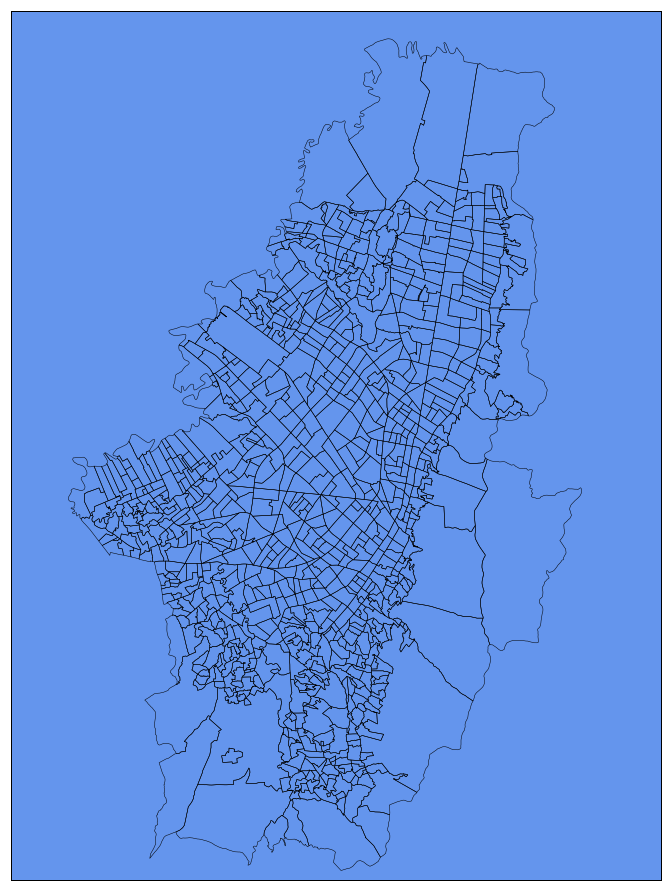

In [5]:
fig, ax = plt.subplots(figsize=(16, 16))

m = Basemap(projection='merc',
            llcrnrlat=4.45,
            llcrnrlon=-74.25,
            urcrnrlat=4.85,
            urcrnrlon=-73.95,
            resolution = 'c',
            ax=ax)

m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='#6495ed', lake_color='aqua')
m.drawcoastlines()
m.readshapefile('./barrios_catastrales/barrios_catastrales_2', 'barrios');

### Conteo de la cantidad de hurtos por barrio en la ciudad
Acá realizamos el conteo de todos los hurtos reportados utilizando los métodos propios de los pandas dataframes. Luego renombramos las columnas del dataframe.

In [6]:
crime_neighborhood = bogota['Barrio'].value_counts()
crime_neighborhood = crime_neighborhood.reset_index()
crime_neighborhood.columns = ['Barrio', 'Cantidad de Hurtos']

In [7]:
crime_neighborhood.head()

,Barrio,Cantidad de Hurtos
0,CHAPINERO CENTRAL E-2,1123
1,TEUSAQUILLO E-13,670
2,PATIO BONITO I E-8,641
3,BELLA SUIZA E-1,530
4,CHAPINERO ALTO E-2,490


Curiosamente, el barrio con mayor cantidad de hurtos reportados para el 2017, casi doblando al segundo es Chapinero Central, así que a andarse con cuidado por allá...

Ahora bien, como tenemos cargado el archivo shape de nuestra ciudad, se sabe que normalmente éstos contienen datos asociados a cada uno de sus polígons. Para nuestra suerte, el archivo contiene el nombre del barrio además de otros cuantos datos que pueden resultar de interés.

Para extraer los datos del shapefile, recorremos el objeto barrios contenido en el mapa y extraemos la forma (shape) para convertirlo en un polígono con la librería matplotlib. Además, extraemos la información del barrio. En este punto, se puede imprimir toda la información para conocer los nombres de los atributos de cada shape. Finalmente, creamos un dataframe que contenga esta información.

In [8]:
df_poly = pd.DataFrame({'Forma': [Polygon(np.array(shape), True) for shape in m.barrios],
                        'Barrio': [area['NOMB_BARR'] for area in m.barrios_info]})

### Unión de los datos
En este punto, contamos con 2 dataframes que contienen, uno los polígonos y el otro la cantidad de hurtos por barrio. Por lo tanto, queremos unir ambos para asociar a cada polígono un numero de hurtos.
Esto lo hacemos con el método merge de pandas. Sin embargo, como los nombres de los barrios no son iguales en ambos, debemos buscar que el nombre de los barrios del dataset de hurtos esté contenido en el dataset de polígonos. Por último llenamos todos los campos con nan con un 0 (por si acaso).

In [9]:
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

for i, row in df_poly.iterrows():
    crime_neighborhood.loc[crime_neighborhood['Barrio'].str.lower().str.contains(row['Barrio'].lower()), 'Barrio'] = row['Barrio']

In [10]:
df_poly = pd.merge(df_poly, crime_neighborhood, left_on='Barrio', right_on='Barrio', how='left')

In [11]:
df_poly.fillna(0, inplace=True)

### El mapa
Creamos entonces otro objeto de basemap y cargamos los colormaps de matplotlib. en este caso seleccioné el cmap *"Orange"*.
Después creamos el un objeto que contendrá las formas de nuestro dataframe, el argumento zorder es para indicar que queremos las formas en la parte superior del mapa. Continuando, normalizamos nuestra cantidad de hurtos para asociarle un color de nuetro colormap para después agregar nuestro colorbar.

Para terminar, agregé una gráfica de barras con los 10 barrios que presentaron el mayor número de hechos durante el año.

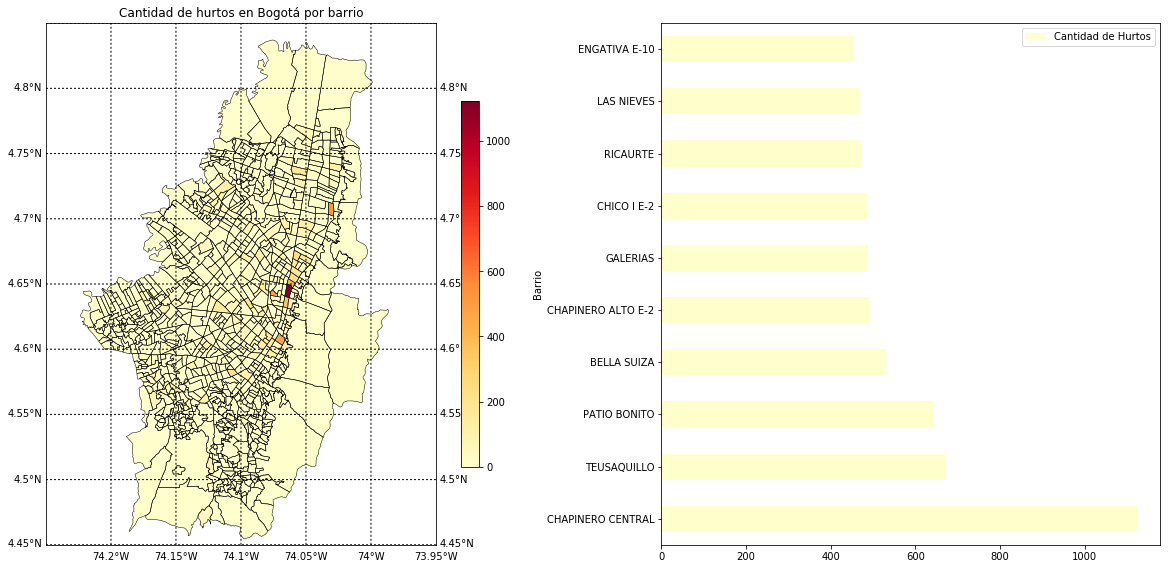

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

m = Basemap(projection='merc',
            llcrnrlat=4.45,
            llcrnrlon=-74.25,
            urcrnrlat=4.85,
            urcrnrlon=-73.95,
            resolution = 'c',
            ax=ax[0])

m.drawparallels(np.arange(0,10,0.05),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-80,-70,0.05),labels=[1,1,0,1])

cmap = plt.get_cmap('YlOrRd')   
pc = PatchCollection(df_poly['Forma'], zorder=2)
norm = Normalize()
 
pc.set_facecolor(cmap(norm(df_poly['Cantidad de Hurtos'].fillna(0).values)))
ax[0].add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
 
mapper.set_array(df_poly['Cantidad de Hurtos'])
fig.colorbar(mapper, ax=ax[0], shrink=0.7)

m.readshapefile('./barrios_catastrales/barrios_catastrales_2', 'barrios')

ax[0].set_title('Cantidad de hurtos en Bogotá por barrio')

crime_neighborhood.set_index('Barrio').head(10).plot.barh(ax=ax[1], cmap=cmap)
fig.tight_layout()

In [16]:
fig.savefig('mapa_hurtos.png', dpi=300)